In [44]:
import os
import shutil
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import plotly.express as px


from shutil import copyfile
from tensorflow.keras.layers import Conv2D,Add,MaxPooling2D, Dense, BatchNormalization,Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

In [45]:
class_names = ['Cat', 'Dog'] 

n_dogs = len(os.listdir('C:\\Users\\Fa2roT\\Desktop\\project_Ai\\PetImages\Dog'))
n_cats = len(os.listdir('C:\\Users\\Fa2roT\\Desktop\\project_Ai\\PetImages\\Cat'))
n_images = [n_cats, n_dogs]
px.pie(names=class_names, values=n_images)

In [46]:
try:
    os.mkdir('/tmp/cats-v-dogs')
    os.mkdir('/tmp/cats-v-dogs/training')
    os.mkdir('/tmp/cats-v-dogs/validation')
    os.mkdir('/tmp/cats-v-dogs/test')
    os.mkdir('/tmp/cats-v-dogs/training/cats')
    os.mkdir('/tmp/cats-v-dogs/training/dogs')
    os.mkdir('/tmp/cats-v-dogs/validation/cats')
    os.mkdir('/tmp/cats-v-dogs/validation/dogs')
    os.mkdir('/tmp/cats-v-dogs/test/cats')
    os.mkdir('/tmp/cats-v-dogs/test/dogs')
except OSError:
    print('Error failed to make directory')

Error failed to make directory


In [47]:
#Define data path
CAT_DIR = 'C:\\Users\\Fa2roT\\Desktop\\project_Ai\\PetImages\\Cat'
DOG_DIR = 'C:\\Users\\Fa2roT\\Desktop\\project_Ai\\PetImages\\Dog'

TRAINING_DIR = "/tmp/cats-v-dogs/training/"
VALIDATION_DIR = "/tmp/cats-v-dogs/validation/"

TRAINING_CATS = os.path.join(TRAINING_DIR, "cats/")
VALIDATION_CATS = os.path.join(VALIDATION_DIR, "cats/")

TRAINING_DOGS = os.path.join(TRAINING_DIR, "dogs/")
VALIDATION_DOGS = os.path.join(VALIDATION_DIR, "dogs/")

# Define whether to include test split or not
INCLUDE_TEST = True

In [48]:
def split_data(main_dir, training_dir, validation_dir, test_dir=None, include_test_split = True,  split_size=0.9):
    """
    Splits the data into train validation and test sets (optional)

    Args:
    main_dir (string):  path containing the images
    training_dir (string):  path to be used for training
    validation_dir (string):  path to be used for validation
    test_dir (string):  path to be used for test
    include_test_split (boolen):  whether to include a test split or not
    split_size (float): size of the dataset to be used for training
    """
    files = []
    for file in os.listdir(main_dir):
        if  os.path.getsize(os.path.join(main_dir, file)): # check if the file's size isn't 0
            files.append(file) # appends file name to a list

    shuffled_files = random.sample(files,  len(files)) # shuffles the data
    split = int(0.9 * len(shuffled_files)) #the training split casted into int for numeric rounding
    train = shuffled_files[:split] #training split
    split_valid_test = int(split + (len(shuffled_files)-split)/2)
   
    if include_test_split:
        validation = shuffled_files[split:split_valid_test] # validation split
        test = shuffled_files[split_valid_test:]
    else:
        validation = shuffled_files[split:]

    for element in train:
        copyfile(os.path.join(main_dir,  element), os.path.join(training_dir, element)) # copy files into training directory

    for element in validation:
        copyfile(os.path.join(main_dir,  element), os.path.join(validation_dir, element))# copy files into validation directory
        
    if include_test_split:
        for element in test:
            copyfile(os.path.join(main_dir,  element), os.path.join(test_dir, element)) # copy files into test directory
    print("Split sucessful!")

In [49]:
split_data(CAT_DIR, '/tmp/cats-v-dogs/training/cats', '/tmp/cats-v-dogs/validation/cats', '/tmp/cats-v-dogs/test/cats',INCLUDE_TEST, 0.9)
split_data(DOG_DIR, '/tmp/cats-v-dogs/training/dogs', '/tmp/cats-v-dogs/validation/dogs','/tmp/cats-v-dogs/test/dogs',INCLUDE_TEST, 0.9)

Split sucessful!
Split sucessful!


In [50]:
print(len(os.listdir('/tmp/cats-v-dogs/training/cats')))
print(len(os.listdir('/tmp/cats-v-dogs/training/dogs')))

print(len(os.listdir('/tmp/cats-v-dogs/validation/cats')))
print(len(os.listdir('/tmp/cats-v-dogs/validation/dogs')))

print(len(os.listdir('/tmp/cats-v-dogs/test/cats')))
print(len(os.listdir('/tmp/cats-v-dogs/test/dogs')))

12488
12491
1797
1778
1780
1770


In [51]:
train_gen = ImageDataGenerator(
        rescale=1./255)


validation_gen =  ImageDataGenerator(
        rescale=1./255.)

if INCLUDE_TEST:
    test_gen =  ImageDataGenerator(
            rescale=1./255.)


In [52]:
train_generator = train_gen.flow_from_directory(
        '/tmp/cats-v-dogs/training',
        target_size=(150, 150),
        batch_size=64,
        class_mode='binary')
validation_generator = validation_gen.flow_from_directory(
        '/tmp/cats-v-dogs/validation',
        target_size=(150, 150),
        batch_size=64,
        class_mode='binary')

if INCLUDE_TEST:
    test_generator = test_gen.flow_from_directory(
        '/tmp/cats-v-dogs/validation',
        target_size=(150, 150),
        batch_size=64,
        class_mode='binary')

Found 24977 images belonging to 2 classes.
Found 3575 images belonging to 2 classes.
Found 3575 images belonging to 2 classes.


In [53]:
class_names = ['Cat', 'Dog']
def plot_data(generator, n_images):
    """
    Plots random data from dataset
    Args:
    generator: a generator instance
    n_images : number of images to plot
    """
    i = 1
    images, labels = generator.next()
    labels = labels.astype('int32')

    plt.figure(figsize=(14, 15))
    
    for image, label in zip(images, labels):
        plt.subplot(4, 3, i)
        plt.imshow(image)
        plt.title(class_names[label])
        plt.axis('off')
        i += 1
        if i == n_images:
            break
    
    plt.show()

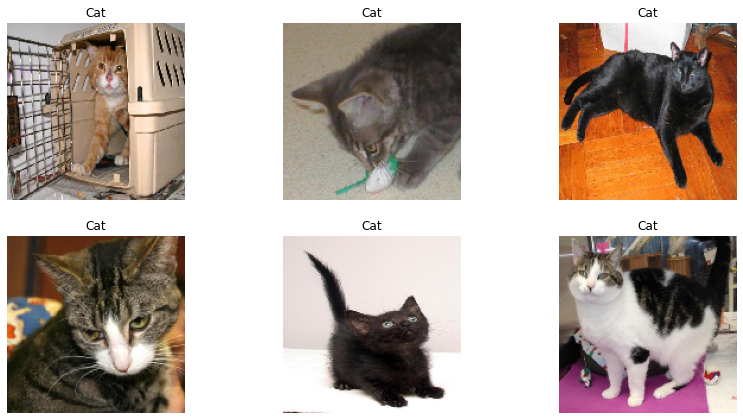

In [54]:
plot_data(train_generator,7)


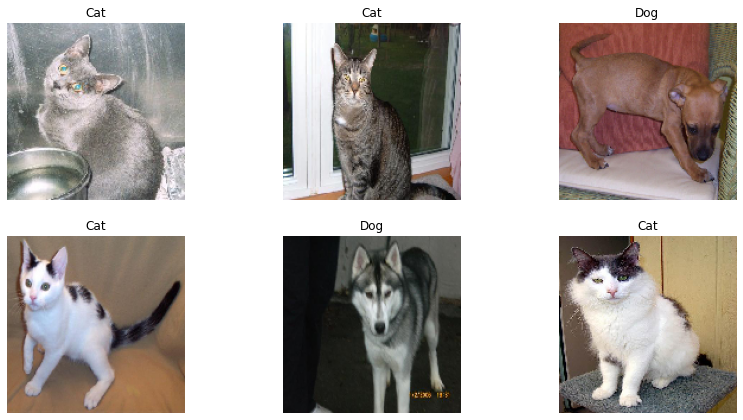

In [55]:
plot_data(validation_generator,7)


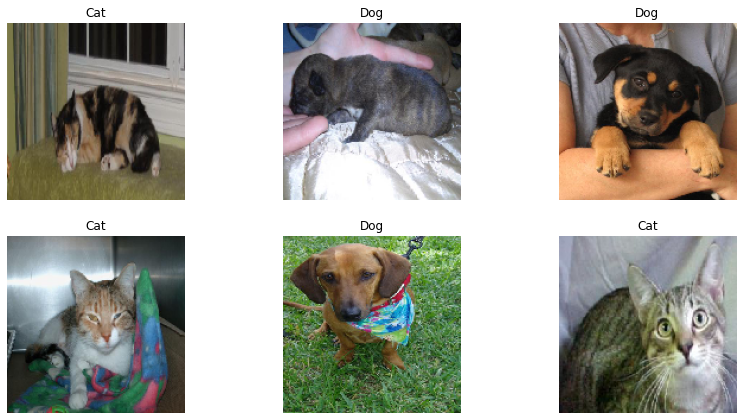

In [56]:
if INCLUDE_TEST:
    plot_data(test_generator, 7)

# DNN

In [57]:
# inputs = tf.keras.layers.Input(shape=(150, 150, 3))
# x = tf.keras.layers.Flatten()(inputs)
# x = Dense(516, activation='relu')(x)
# x = Dense(256, activation='relu')(x)
# x = Dense(128, activation='relu')(x)
# x = tf.keras.layers.Dense(2, activation='softmax')(x)

# model_dnn = Model(inputs=inputs, outputs=x)

In [58]:
# model_dnn.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
#               loss='sparse_categorical_crossentropy',
#               metrics = ['accuracy'])

In [59]:
# dnn_history = model_dnn.fit(
#         train_generator,
#         epochs=15,#Training longer could yield better results
#         validation_data=validation_generator)

Epoch 1/15
391/391 [==============================] - 98s 246ms/step - loss: 3.3708 - accuracy: 0.5019 - val_loss: 0.6932 - val_accuracy: 0.5015
Epoch 2/15
391/391 [==============================] - 100s 256ms/step - loss: 0.7118 - accuracy: 0.5042 - val_loss: 0.6887 - val_accuracy: 0.5223
Epoch 3/15
391/391 [==============================] - 97s 247ms/step - loss: 0.6935 - accuracy: 0.5161 - val_loss: 0.6930 - val_accuracy: 0.5026
Epoch 4/15
391/391 [==============================] - 95s 242ms/step - loss: 0.6879 - accuracy: 0.5232 - val_loss: 0.6848 - val_accuracy: 0.5212
Epoch 5/15
391/391 [==============================] - 95s 244ms/step - loss: 0.6865 - accuracy: 0.5239 - val_loss: 0.6842 - val_accuracy: 0.5313
Epoch 6/15
391/391 [==============================] - 95s 242ms/step - loss: 0.6846 - accuracy: 0.5325 - val_loss: 0.6836 - val_accuracy: 0.5303
Epoch 7/15
391/391 [==============================] - 94s 240ms/step - loss: 0.6836 - accuracy: 0.5311 - val_loss: 0.6834 - val_accuracy: 0.5279
Epoch 8/15
391/391 [==============================] - 94s 241ms/step - loss: 0.6838 - accuracy: 0.5297 - val_loss: 0.6806 - val_accuracy: 0.5357
Epoch 9/15
391/391 [==============================] - 94s 241ms/step - loss: 0.6828 - accuracy: 0.5345 - val_loss: 0.6801 - val_accuracy: 0.5322
Epoch 10/15
391/391 [==============================] - 97s 247ms/step - loss: 0.6816 - accuracy: 0.5349 - val_loss: 0.6796 - val_accuracy: 0.5348
Epoch 11/15
391/391 [==============================] - 93s 238ms/step - loss: 0.6811 - accuracy: 0.5371 - val_loss: 0.6794 - val_accuracy: 0.5363
Epoch 12/15
391/391 [==============================] - 96s 246ms/step - loss: 0.6811 - accuracy: 0.5373 - val_loss: 0.6783 - val_accuracy: 0.5378
Epoch 13/15
391/391 [==============================] - 95s 243ms/step - loss: 0.6797 - accuracy: 0.5405 - val_loss: 0.6799 - val_accuracy: 0.5305
Epoch 14/15
391/391 [==============================] - 93s 239ms/step - loss: 0.6795 - accuracy: 0.5387 - val_loss: 0.6772 - val_accuracy: 0.5391
Epoch 15/15
391/391 [==============================] - 93s 239ms/step - loss: 0.6793 - accuracy: 0.5367 - val_loss: 0.6759 - val_accuracy: 0.5413

In [60]:
model_dnn =  tf.keras.models.load_model('model_dnn.h5')

In [61]:
model_dnn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 flatten (Flatten)           (None, 67500)             0         
                                                                 
 dense (Dense)               (None, 516)               34830516  
                                                                 
 dense_1 (Dense)             (None, 256)               132352    
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 2)                 258       
                                                                 
Total params: 34,996,022
Trainable params: 34,996,022
Non-tra

# CNN

In [62]:
# inputs = tf.keras.layers.Input(shape=(150,150,3))
# x =  tf.keras.layers.Conv2D(32, (3,3), activation='relu')(inputs)
# x = tf.keras.layers.Conv2D(64, (3,3), activation='relu')(x)
# x = tf.keras.layers.MaxPooling2D(2,2)(x)

# x = tf.keras.layers.Conv2D(64, (3,3), activation='relu')(x)
# x = tf.keras.layers.Conv2D(128, (3,3), activation='relu')(x)
# x = tf.keras.layers.MaxPooling2D(2,2)(x)

# x = tf.keras.layers.Conv2D(128, (3,3), activation='relu')(x)
# x = tf.keras.layers.Conv2D(256, (3,3), activation='relu')(x)
# x = tf.keras.layers.GlobalAveragePooling2D()(x)
# x = Dense(1024,activation='relu')(x)
# x = tf.keras.layers.Dense(2, activation='softmax')(x) 

# cnn_model = Model(inputs=inputs, outputs=x)

In [63]:
# cnn_model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
#               loss='sparse_categorical_crossentropy',
#               metrics = ['accuracy'])

In [64]:
# cnn_results = cnn_model.fit(
#         train_generator,`
#         epochs=15,#Training longer could yield better results
#         validation_data=validation_generator)

Epoch 1/15
391/391 [==============================] - 121s 289ms/step - loss: 0.6862 - accuracy: 0.5631 - val_loss: 0.6686 - val_accuracy: 0.6029
Epoch 2/15
391/391 [==============================] - 107s 272ms/step - loss: 0.6257 - accuracy: 0.6521 - val_loss: 0.5704 - val_accuracy: 0.7087
Epoch 3/15
391/391 [==============================] - 107s 275ms/step - loss: 0.5823 - accuracy: 0.6952 - val_loss: 0.5578 - val_accuracy: 0.7314
Epoch 4/15
391/391 [==============================] - 109s 279ms/step - loss: 0.5579 - accuracy: 0.7282 - val_loss: 0.5103 - val_accuracy: 0.7548
Epoch 5/15
391/391 [==============================] - 106s 271ms/step - loss: 0.5165 - accuracy: 0.7512 - val_loss: 0.6932 - val_accuracy: 0.6517
Epoch 6/15
391/391 [==============================] - 108s 275ms/step - loss: 0.4830 - accuracy: 0.7758 - val_loss: 0.5157 - val_accuracy: 0.7606
Epoch 7/15
391/391 [==============================] - 106s 271ms/step - loss: 0.4530 - accuracy: 0.7920 - val_loss: 0.4005 - val_accuracy: 0.8336
Epoch 8/15
391/391 [==============================] - 106s 272ms/step - loss: 0.4196 - accuracy: 0.8125 - val_loss: 0.5176 - val_accuracy: 0.7344
Epoch 9/15
391/391 [==============================] - 105s 267ms/step - loss: 0.3874 - accuracy: 0.8305 - val_loss: 0.3081 - val_accuracy: 0.8792
Epoch 10/15
391/391 [==============================] - 105s 268ms/step - loss: 0.3589 - accuracy: 0.8463 - val_loss: 0.3648 - val_accuracy: 0.8397
Epoch 11/15
391/391 [==============================] - 105s 269ms/step - loss: 0.3269 - accuracy: 0.8612 - val_loss: 0.2633 - val_accuracy: 0.8984
Epoch 12/15
391/391 [==============================] - 106s 271ms/step - loss: 0.2989 - accuracy: 0.8773 - val_loss: 0.2003 - val_accuracy: 0.9226
Epoch 13/15
391/391 [==============================] - 104s 267ms/step - loss: 0.2853 - accuracy: 0.8819 - val_loss: 0.2039 - val_accuracy: 0.9205
Epoch 14/15
391/391 [==============================] - 105s 267ms/step - loss: 0.2573 - accuracy: 0.8956 - val_loss: 0.2047 - val_accuracy: 0.9311
Epoch 15/15
391/391 [==============================] - 108s 277ms/step - loss: 0.2406 - accuracy: 0.9045 - val_loss: 0.1937 - val_accuracy: 0.9270

In [65]:
model_cnn =  tf.keras.models.load_model('model_cnn.h5')

In [66]:
model_cnn.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 146, 146, 64)      18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 73, 73, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 64)        36928     
                                                                 
 conv2d_3 (Conv2D)           (None, 69, 69, 128)       73856     
                                                           

# VGG-16

In [67]:
# # Define base model
# base_model = tf.keras.applications.VGG16(input_shape=(150,150, 3), include_top=False, weights='imagenet')
# # we want to freeze all layers at first
# for layer in base_model.layers[:-1]:
#     layer.trainable = False

# # Create input layer
# inputs = tf.keras.layers.Input(shape=(150,150,3), name="Input_Layer")

# # Give base models the inputs
# x = base_model(inputs, training=False)

# # Add global pooling to condense x into a feature vector
# x = tf.keras.layers.GlobalAveragePooling2D(name="Pooling_Layer")(x)

# # Put a dense layer on top for the outputs
# outputs = tf.keras.layers.Dense(2, activation="softmax", name="Output_Layer")(x)

# # Make a model using inputs and outputs
# model_finetuned = Model(inputs, outputs)


In [68]:
# # Compile the model
# model_finetuned.compile(loss = "sparse_categorical_crossentropy", 
#                 optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
#                 metrics = ["accuracy"])

In [69]:
# finetuned_results = model_finetuned.fit(
#         train_generator,
#         epochs=15,#Training longer could yield better results
#         validation_data=validation_generator)

Epoch 1/15
391/391 [==============================] - 110s 280ms/step - loss: 0.4445 - accuracy: 0.8073 - val_loss: 0.3407 - val_accuracy: 0.8643
Epoch 2/15
391/391 [==============================] - 107s 275ms/step - loss: 0.3107 - accuracy: 0.8744 - val_loss: 0.2946 - val_accuracy: 0.8818
Epoch 3/15
391/391 [==============================] - 108s 275ms/step - loss: 0.2807 - accuracy: 0.8851 - val_loss: 0.2743 - val_accuracy: 0.8889
Epoch 4/15
391/391 [==============================] - 109s 279ms/step - loss: 0.2648 - accuracy: 0.8911 - val_loss: 0.2625 - val_accuracy: 0.8939
Epoch 5/15
391/391 [==============================] - 108s 275ms/step - loss: 0.2550 - accuracy: 0.8943 - val_loss: 0.2530 - val_accuracy: 0.8976
Epoch 6/15
391/391 [==============================] - 108s 277ms/step - loss: 0.2483 - accuracy: 0.8965 - val_loss: 0.2471 - val_accuracy: 0.8984
Epoch 7/15
391/391 [==============================] - 107s 274ms/step - loss: 0.2426 - accuracy: 0.8987 - val_loss: 0.2424 - val_accuracy: 0.9008
Epoch 8/15
391/391 [==============================] - 108s 277ms/step - loss: 0.2385 - accuracy: 0.9009 - val_loss: 0.2391 - val_accuracy: 0.9049
Epoch 9/15
391/391 [==============================] - 111s 283ms/step - loss: 0.2354 - accuracy: 0.9019 - val_loss: 0.2356 - val_accuracy: 0.9025
Epoch 10/15
391/391 [==============================] - 108s 277ms/step - loss: 0.2328 - accuracy: 0.9041 - val_loss: 0.2341 - val_accuracy: 0.9056
Epoch 11/15
391/391 [==============================] - 107s 274ms/step - loss: 0.2300 - accuracy: 0.9040 - val_loss: 0.2339 - val_accuracy: 0.9067
Epoch 12/15
391/391 [==============================] - 110s 280ms/step - loss: 0.2280 - accuracy: 0.9044 - val_loss: 0.2283 - val_accuracy: 0.9071
Epoch 13/15
391/391 [==============================] - 108s 276ms/step - loss: 0.2265 - accuracy: 0.9054 - val_loss: 0.2273 - val_accuracy: 0.9073
Epoch 14/15
391/391 [==============================] - 108s 277ms/step - loss: 0.2245 - accuracy: 0.9059 - val_loss: 0.2251 - val_accuracy: 0.9095
Epoch 15/15
391/391 [==============================] - 110s 280ms/step - loss: 0.2236 - accuracy: 0.9064 - val_loss: 0.2234 - val_accuracy: 0.9086

In [70]:
model_finetuned =  tf.keras.models.load_model('model_finetuned.h5')

In [71]:
model_finetuned.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_Layer (InputLayer)    [(None, 150, 150, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 Pooling_Layer (GlobalAverag  (None, 512)              0         
 ePooling2D)                                                     
                                                                 
 Output_Layer (Dense)        (None, 2)                 1026      
                                                                 
Total params: 14,715,714
Trainable params: 1,026
Non-trainable params: 14,714,688
_________________________________________________________________


# Evaluation

In [34]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score, balanced_accuracy_score

def evaluate_model(model, data_generator):
    '''
    Keyword arguments:
    model -- Keras model
    data_generator -- Generator object yielding batches of data

    returns a dataframe for evaluating metrics
    '''
    y_test = []  # List to store ground truth labels
    predictions = []

    num_iterations = len(data_generator)  # Get the number of iterations
    with tqdm(total=num_iterations, desc='Batches') as pbar_outer:
        for i, (batch_X, batch_y) in enumerate(data_generator):
            batch_predictions = model.predict(batch_X)
            predictions.extend(batch_predictions)
            y_test.extend(batch_y)
            pbar_outer.update(1)

            if i == num_iterations - 1:
                break

        pbar_outer.close()
    
    # convert lists to numpy arrays for metric calculations
    y_test = np.array(y_test)
    predictions = np.array(predictions)
    predictions = np.argmax(predictions, axis=1)

    # compute metrics for evaluation
    accuracy = accuracy_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    balanced_accuracy = balanced_accuracy_score(y_test, predictions)

    # create a dataframe to visualize the results
    eval_df = pd.DataFrame([[accuracy, f1, precision, recall, balanced_accuracy]], columns=['accuracy', 'f1_score', 'precision', 'recall', 'balanced_accuracy'])
    return eval_df

In [35]:
results = evaluate_model(model_dnn,test_generator)

Batches:   0%|          | 0/38 [00:00<?, ?it/s]

2/2 [==============================] - 0s 16ms/step


Batches:   3%|▎         | 1/38 [00:00<00:10,  3.47it/s]

2/2 [==============================] - 0s 17ms/step


Batches:   5%|▌         | 2/38 [00:00<00:08,  4.27it/s]

2/2 [==============================] - 0s 17ms/step


Batches:   8%|▊         | 3/38 [00:00<00:07,  4.68it/s]

2/2 [==============================] - 0s 17ms/step


Batches:  11%|█         | 4/38 [00:00<00:07,  4.79it/s]

2/2 [==============================] - 0s 18ms/step


Batches:  13%|█▎        | 5/38 [00:01<00:06,  4.86it/s]

2/2 [==============================] - 0s 17ms/step


Batches:  16%|█▌        | 6/38 [00:01<00:06,  5.02it/s]

2/2 [==============================] - 0s 17ms/step


Batches:  18%|█▊        | 7/38 [00:01<00:06,  5.12it/s]

2/2 [==============================] - 0s 18ms/step


Batches:  21%|██        | 8/38 [00:01<00:05,  5.27it/s]

2/2 [==============================] - 0s 21ms/step


Batches:  24%|██▎       | 9/38 [00:01<00:05,  5.19it/s]

2/2 [==============================] - 0s 18ms/step


Batches:  26%|██▋       | 10/38 [00:02<00:05,  5.19it/s]

2/2 [==============================] - 0s 16ms/step


Batches:  29%|██▉       | 11/38 [00:02<00:05,  5.13it/s]

2/2 [==============================] - 0s 19ms/step


Batches:  32%|███▏      | 12/38 [00:02<00:05,  5.12it/s]

2/2 [==============================] - 0s 18ms/step


Batches:  34%|███▍      | 13/38 [00:02<00:04,  5.13it/s]

2/2 [==============================] - 0s 18ms/step


Batches:  37%|███▋      | 14/38 [00:02<00:04,  5.16it/s]

2/2 [==============================] - 0s 16ms/step


Batches:  39%|███▉      | 15/38 [00:02<00:04,  5.19it/s]

2/2 [==============================] - 0s 17ms/step


Batches:  42%|████▏     | 16/38 [00:03<00:04,  5.16it/s]

2/2 [==============================] - 0s 17ms/step


Batches:  45%|████▍     | 17/38 [00:03<00:04,  5.18it/s]

2/2 [==============================] - 0s 17ms/step


Batches:  47%|████▋     | 18/38 [00:03<00:03,  5.14it/s]

2/2 [==============================] - 0s 18ms/step


Batches:  50%|█████     | 19/38 [00:03<00:03,  5.18it/s]

2/2 [==============================] - 0s 19ms/step


Batches:  53%|█████▎    | 20/38 [00:03<00:03,  5.19it/s]

2/2 [==============================] - 0s 19ms/step


Batches:  55%|█████▌    | 21/38 [00:04<00:03,  5.20it/s]

2/2 [==============================] - 0s 21ms/step


Batches:  58%|█████▊    | 22/38 [00:04<00:03,  5.10it/s]

2/2 [==============================] - 0s 20ms/step


Batches:  61%|██████    | 23/38 [00:04<00:03,  4.96it/s]

2/2 [==============================] - 0s 20ms/step


Batches:  63%|██████▎   | 24/38 [00:04<00:02,  4.93it/s]

2/2 [==============================] - 0s 19ms/step


Batches:  66%|██████▌   | 25/38 [00:05<00:02,  4.67it/s]

2/2 [==============================] - 0s 19ms/step


Batches:  68%|██████▊   | 26/38 [00:05<00:02,  4.65it/s]

2/2 [==============================] - 0s 19ms/step


Batches:  71%|███████   | 27/38 [00:05<00:02,  4.73it/s]

2/2 [==============================] - 0s 20ms/step


Batches:  74%|███████▎  | 28/38 [00:05<00:02,  4.70it/s]

2/2 [==============================] - 0s 20ms/step


Batches:  76%|███████▋  | 29/38 [00:05<00:01,  4.70it/s]

2/2 [==============================] - 0s 18ms/step


Batches:  79%|███████▉  | 30/38 [00:06<00:01,  4.69it/s]

2/2 [==============================] - 0s 18ms/step


Batches:  82%|████████▏ | 31/38 [00:06<00:01,  4.65it/s]

2/2 [==============================] - 0s 18ms/step


Batches:  84%|████████▍ | 32/38 [00:06<00:01,  4.66it/s]

2/2 [==============================] - 0s 17ms/step


Batches:  87%|████████▋ | 33/38 [00:06<00:01,  4.92it/s]

2/2 [==============================] - 0s 20ms/step


Batches:  89%|████████▉ | 34/38 [00:06<00:00,  4.77it/s]

2/2 [==============================] - 0s 19ms/step


Batches:  92%|█████████▏| 35/38 [00:07<00:00,  4.76it/s]

2/2 [==============================] - 0s 18ms/step


Batches:  95%|█████████▍| 36/38 [00:07<00:00,  4.80it/s]

2/2 [==============================] - 0s 18ms/step


Batches:  97%|█████████▋| 37/38 [00:07<00:00,  4.58it/s]

2/2 [==============================] - 0s 20ms/step


Batches: 100%|██████████| 38/38 [00:07<00:00,  4.87it/s]


In [36]:
results.index = ['DNN']

In [38]:
cnn_results = evaluate_model(model_cnn, test_generator)

cnn_results.index = ['CNN']

results = results.append(cnn_results)

Batches:   0%|          | 0/38 [00:00<?, ?it/s]

2/2 [==============================] - 1s 225ms/step


Batches:   3%|▎         | 1/38 [00:00<00:24,  1.53it/s]

2/2 [==============================] - 0s 234ms/step


Batches:   5%|▌         | 2/38 [00:01<00:22,  1.58it/s]

2/2 [==============================] - 0s 229ms/step


Batches:   8%|▊         | 3/38 [00:01<00:21,  1.61it/s]

2/2 [==============================] - 0s 226ms/step


Batches:  11%|█         | 4/38 [00:02<00:20,  1.63it/s]

2/2 [==============================] - 0s 239ms/step


Batches:  13%|█▎        | 5/38 [00:03<00:20,  1.61it/s]

2/2 [==============================] - 0s 236ms/step


Batches:  16%|█▌        | 6/38 [00:03<00:19,  1.61it/s]

2/2 [==============================] - 0s 225ms/step


Batches:  18%|█▊        | 7/38 [00:04<00:19,  1.59it/s]

2/2 [==============================] - 0s 233ms/step


Batches:  21%|██        | 8/38 [00:04<00:18,  1.60it/s]

2/2 [==============================] - 0s 230ms/step


Batches:  24%|██▎       | 9/38 [00:05<00:18,  1.61it/s]

2/2 [==============================] - 0s 233ms/step


Batches:  26%|██▋       | 10/38 [00:06<00:17,  1.61it/s]

2/2 [==============================] - 0s 229ms/step


Batches:  29%|██▉       | 11/38 [00:06<00:16,  1.61it/s]

2/2 [==============================] - 0s 241ms/step


Batches:  32%|███▏      | 12/38 [00:07<00:16,  1.58it/s]

2/2 [==============================] - 0s 246ms/step


Batches:  34%|███▍      | 13/38 [00:08<00:15,  1.57it/s]

2/2 [==============================] - 0s 233ms/step


Batches:  37%|███▋      | 14/38 [00:08<00:15,  1.59it/s]

2/2 [==============================] - 0s 227ms/step


Batches:  39%|███▉      | 15/38 [00:09<00:14,  1.59it/s]

2/2 [==============================] - 0s 233ms/step


Batches:  42%|████▏     | 16/38 [00:10<00:13,  1.60it/s]

2/2 [==============================] - 0s 232ms/step


Batches:  45%|████▍     | 17/38 [00:10<00:13,  1.61it/s]

2/2 [==============================] - 0s 234ms/step


Batches:  47%|████▋     | 18/38 [00:11<00:12,  1.61it/s]

2/2 [==============================] - 0s 240ms/step


Batches:  50%|█████     | 19/38 [00:11<00:11,  1.61it/s]

2/2 [==============================] - 0s 239ms/step


Batches:  53%|█████▎    | 20/38 [00:12<00:11,  1.60it/s]

2/2 [==============================] - 1s 255ms/step


Batches:  55%|█████▌    | 21/38 [00:13<00:10,  1.57it/s]

2/2 [==============================] - 0s 235ms/step


Batches:  58%|█████▊    | 22/38 [00:13<00:10,  1.58it/s]

2/2 [==============================] - 1s 260ms/step


Batches:  61%|██████    | 23/38 [00:14<00:09,  1.56it/s]

2/2 [==============================] - 1s 272ms/step


Batches:  63%|██████▎   | 24/38 [00:15<00:09,  1.53it/s]

2/2 [==============================] - 1s 248ms/step


Batches:  66%|██████▌   | 25/38 [00:15<00:08,  1.52it/s]

2/2 [==============================] - 0s 240ms/step


Batches:  68%|██████▊   | 26/38 [00:16<00:07,  1.53it/s]

2/2 [==============================] - 0s 244ms/step


Batches:  71%|███████   | 27/38 [00:17<00:07,  1.55it/s]

2/2 [==============================] - 0s 238ms/step


Batches:  74%|███████▎  | 28/38 [00:17<00:06,  1.55it/s]

2/2 [==============================] - 0s 237ms/step


Batches:  76%|███████▋  | 29/38 [00:18<00:05,  1.56it/s]

2/2 [==============================] - 0s 236ms/step


Batches:  79%|███████▉  | 30/38 [00:18<00:05,  1.57it/s]

2/2 [==============================] - 0s 243ms/step


Batches:  82%|████████▏ | 31/38 [00:19<00:04,  1.57it/s]

2/2 [==============================] - 0s 243ms/step


Batches:  84%|████████▍ | 32/38 [00:20<00:03,  1.57it/s]

2/2 [==============================] - 0s 238ms/step


Batches:  87%|████████▋ | 33/38 [00:20<00:03,  1.58it/s]

2/2 [==============================] - 1s 244ms/step


Batches:  89%|████████▉ | 34/38 [00:21<00:02,  1.57it/s]

2/2 [==============================] - 1s 258ms/step


Batches:  92%|█████████▏| 35/38 [00:22<00:01,  1.55it/s]

2/2 [==============================] - 0s 240ms/step


Batches:  95%|█████████▍| 36/38 [00:22<00:01,  1.55it/s]

2/2 [==============================] - 1s 219ms/step


Batches:  97%|█████████▋| 37/38 [00:23<00:00,  1.52it/s]

2/2 [==============================] - 1s 281ms/step


Batches: 100%|██████████| 38/38 [00:24<00:00,  1.57it/s]


In [39]:
finetuned_results = evaluate_model(model_finetuned, test_generator)

finetuned_results.index = ['Fine-tuned']

results = results.append(finetuned_results)

Batches:   0%|          | 0/38 [00:00<?, ?it/s]

2/2 [==============================] - 2s 839ms/step


Batches:   3%|▎         | 1/38 [00:01<01:10,  1.90s/it]

2/2 [==============================] - 2s 825ms/step


Batches:   5%|▌         | 2/38 [00:03<01:06,  1.85s/it]

2/2 [==============================] - 2s 853ms/step


Batches:   8%|▊         | 3/38 [00:05<01:04,  1.84s/it]

2/2 [==============================] - 2s 850ms/step


Batches:  11%|█         | 4/38 [00:07<01:03,  1.85s/it]

2/2 [==============================] - 2s 897ms/step


Batches:  13%|█▎        | 5/38 [00:09<01:02,  1.89s/it]

2/2 [==============================] - 2s 878ms/step


Batches:  16%|█▌        | 6/38 [00:11<01:00,  1.89s/it]

2/2 [==============================] - 2s 866ms/step


Batches:  18%|█▊        | 7/38 [00:13<00:58,  1.88s/it]

2/2 [==============================] - 2s 922ms/step


Batches:  21%|██        | 8/38 [00:15<00:58,  1.94s/it]

2/2 [==============================] - 2s 942ms/step


Batches:  24%|██▎       | 9/38 [00:17<00:57,  1.97s/it]

2/2 [==============================] - 2s 925ms/step


Batches:  26%|██▋       | 10/38 [00:19<00:55,  1.98s/it]

2/2 [==============================] - 2s 871ms/step


Batches:  29%|██▉       | 11/38 [00:21<00:52,  1.95s/it]

2/2 [==============================] - 2s 886ms/step


Batches:  32%|███▏      | 12/38 [00:23<00:50,  1.96s/it]

2/2 [==============================] - 2s 969ms/step


Batches:  34%|███▍      | 13/38 [00:25<00:49,  1.98s/it]

2/2 [==============================] - 2s 879ms/step


Batches:  37%|███▋      | 14/38 [00:27<00:47,  1.97s/it]

2/2 [==============================] - 2s 905ms/step


Batches:  39%|███▉      | 15/38 [00:29<00:45,  1.97s/it]

2/2 [==============================] - 2s 867ms/step


Batches:  42%|████▏     | 16/38 [00:30<00:42,  1.95s/it]

2/2 [==============================] - 2s 893ms/step


Batches:  45%|████▍     | 17/38 [00:32<00:40,  1.95s/it]

2/2 [==============================] - 2s 894ms/step


Batches:  47%|████▋     | 18/38 [00:34<00:38,  1.94s/it]

2/2 [==============================] - 2s 892ms/step


Batches:  50%|█████     | 19/38 [00:36<00:36,  1.94s/it]

2/2 [==============================] - 2s 924ms/step


Batches:  53%|█████▎    | 20/38 [00:38<00:35,  1.96s/it]

2/2 [==============================] - 2s 940ms/step


Batches:  55%|█████▌    | 21/38 [00:40<00:33,  1.97s/it]

2/2 [==============================] - 2s 894ms/step


Batches:  58%|█████▊    | 22/38 [00:42<00:31,  1.97s/it]

2/2 [==============================] - 2s 894ms/step


Batches:  61%|██████    | 23/38 [00:44<00:29,  1.97s/it]

2/2 [==============================] - 2s 899ms/step


Batches:  63%|██████▎   | 24/38 [00:46<00:27,  1.96s/it]

2/2 [==============================] - 2s 891ms/step


Batches:  66%|██████▌   | 25/38 [00:48<00:25,  1.96s/it]

2/2 [==============================] - 2s 893ms/step


Batches:  68%|██████▊   | 26/38 [00:50<00:23,  1.96s/it]

2/2 [==============================] - 2s 892ms/step


Batches:  71%|███████   | 27/38 [00:52<00:21,  1.96s/it]

2/2 [==============================] - 2s 913ms/step


Batches:  74%|███████▎  | 28/38 [00:54<00:19,  1.96s/it]

2/2 [==============================] - 2s 951ms/step


Batches:  76%|███████▋  | 29/38 [00:56<00:17,  1.99s/it]

2/2 [==============================] - 2s 889ms/step


Batches:  79%|███████▉  | 30/38 [00:58<00:15,  1.99s/it]

2/2 [==============================] - 2s 910ms/step


Batches:  82%|████████▏ | 31/38 [01:00<00:13,  1.99s/it]

2/2 [==============================] - 2s 918ms/step


Batches:  84%|████████▍ | 32/38 [01:02<00:11,  1.99s/it]

2/2 [==============================] - 2s 909ms/step


Batches:  87%|████████▋ | 33/38 [01:04<00:09,  1.99s/it]

2/2 [==============================] - 2s 901ms/step


Batches:  89%|████████▉ | 34/38 [01:06<00:07,  1.98s/it]

2/2 [==============================] - 2s 944ms/step


Batches:  92%|█████████▏| 35/38 [01:08<00:05,  1.98s/it]

2/2 [==============================] - 2s 943ms/step


Batches:  95%|█████████▍| 36/38 [01:10<00:03,  2.00s/it]

2/2 [==============================] - 2s 818ms/step


Batches:  97%|█████████▋| 37/38 [01:12<00:01,  1.99s/it]

2/2 [==============================] - 2s 919ms/step


Batches: 100%|██████████| 38/38 [01:14<00:00,  1.96s/it]


In [40]:
results

,accuracy,f1_score,precision,recall,balanced_accuracy
DNN,0.530696,0.673171,0.514925,0.971831,0.533047
CNN,0.924598,0.921895,0.955752,0.890354,0.924584
Fine-tuned,0.913061,0.911382,0.919492,0.903414,0.912963


# Accuracy

In [41]:
def display_accuracy(model, generator, dataset_type):
    """
    Displays the accuracy of a model on a given dataset type (train, validation, test)

    Args:
    model: the loaded model
    generator: the data generator for the dataset type
    dataset_type: string representing the dataset type (train, validation, test)
    """
    loss, accuracy = model.evaluate(generator)
    print(f'{dataset_type} accuracy: {accuracy}')




# DNN

In [42]:
# Display accuracy for the training set
display_accuracy(model_dnn, train_generator, 'Train')

# Display accuracy for the validation set
display_accuracy(model_dnn, validation_generator, 'Validation')

# Display accuracy for the test set (if included)
if INCLUDE_TEST:
    display_accuracy(model_dnn, test_generator, 'Test')

 93/387 [======>.......................] - ETA: 40s - loss: 0.6776 - accuracy: 0.5422

C:\Users\Fa2roT\anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:819: UserWarning:

Truncated File Read



387/387 [==============================] - 54s 139ms/step - loss: 0.6752 - accuracy: 0.5415
Train accuracy: 0.5415353775024414
38/38 [==============================] - 5s 139ms/step - loss: 0.6758 - accuracy: 0.5295
Validation accuracy: 0.5294602513313293
38/38 [==============================] - 5s 136ms/step - loss: 0.6758 - accuracy: 0.5295
Test accuracy: 0.5294602513313293


# Customized CNN

In [20]:
# Display accuracy for the training set
display_accuracy(model_cnn, train_generator, 'Train')

# Display accuracy for the validation set
display_accuracy(model_cnn, validation_generator, 'Validation')

# Display accuracy for the test set (if included)
if INCLUDE_TEST:
    display_accuracy(model_cnn, test_generator, 'Test')


387/387 [==============================] - 201s 518ms/step - loss: 0.1980 - accuracy: 0.9225
Train accuracy: 0.9225454330444336
38/38 [==============================] - 21s 538ms/step - loss: 0.1936 - accuracy: 0.9246
Validation accuracy: 0.9245982766151428
38/38 [==============================] - 21s 540ms/step - loss: 0.1936 - accuracy: 0.9246
Test accuracy: 0.9245982766151428


# VGG-16

In [43]:
# Display accuracy for the training set
display_accuracy(model_finetuned, train_generator, 'Train')

# Display accuracy for the validation set
display_accuracy(model_finetuned, validation_generator, 'Validation')

# Display accuracy for the test set (if included)
if INCLUDE_TEST:
    display_accuracy(model_finetuned, test_generator, 'Test')

387/387 [==============================] - 777s 2s/step - loss: 0.2210 - accuracy: 0.9086
Train accuracy: 0.9086060523986816
38/38 [==============================] - 74s 2s/step - loss: 0.2046 - accuracy: 0.9155
Validation accuracy: 0.9155336022377014
38/38 [==============================] - 73s 2s/step - loss: 0.2046 - accuracy: 0.9155
Test accuracy: 0.9155336022377014


# Conclusion


The highest values of Accuracy at 94%, F1-score at 92%, Precision at 96% and Recall at 90% were achieved by the CNN Classifier when compared to others judged on their Performance Metrics. However, the CNN model which is finetuned performed satisfactorily although some parameters like precision, recall, F1score, balanced accuracy, and accuracy had fewer percentage scores.Scoring just 53.07%, the DNN classifier had a low overall performance with below average scores in every metric.The best performance among these three classifiers was recorded by CNN followed by its fine-tuning, while the DNN performed comparatively weakly.